In [9]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

from torchsummary import summary

import sys
sys.path.append("../../")
from utils import metrics
from utils.logger import Logger
import logging

In [10]:
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def sequence_target_generator(raw_data, window_size=16):
    """
    description:
        输入时间序列，根据时间系列生成样本（特征和标签）
    parameters:
        raw_data: 原始时间序列
        Window_size: 滑动窗口长度
    returns:
        features: 生成的特征集合
        labels: 生成的标签集合
    """
    # raw_data = np.array(raw_data) if type(raw_data) is not np.ndarray else raw_data
    # features, labels = [], []
    sample = []
    for i in range(len(raw_data) - window_size):
        sample.append([raw_data[i:i + window_size], raw_data[i + window_size]])
        # features.append(raw_data[i:i + window_size])
        # labels.append(raw_data[i + window_size])
    # return features, labels
    return sample

def generate_sequences(raw_data, tw, pw):
    """
    paras:
        data: raw time serise - numpy ndarray of the univariate time-series
        tw: Training Window - Integer defining how many steps to look back
        pw: Prediction Window - Integer defining how many steps to predict
    returns:
        dictionary of sequences and targets for all sequences
    """
    data = dict()
    raw_data_length = len(raw_data)
    for i in range(raw_data_length - tw):
        sequence = raw_data[i:i + tw]
        target = raw_data[i + tw : i + tw + pw]
        data[i] = {
            "sequence": sequence,
            "target": target
        }
    return data

In [11]:
def evaluation(gt, pred, threshold):
    """
    des:
    paras:
    return:
    """
    
    return

def loss_curve_visualization(tr, va):
    """"
    des:
        打印训练集和验证集上的loss曲线
    """
    fig, ax = plt.subplot()
    ax.plot(tr, label="train")
    ax.plot(va, label="validation")
    plt.show()

In [12]:
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        sequence = sample[0].reshape(-1, 1)
        target = sample[1]
        return torch.FloatTensor(sequence), torch.tensor([target])

In [13]:
USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"
print(f"using device: {device}")

class LSTMNet(nn.Module):
    """
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    sequence_len: number of steps to look back at for prediction
    n_lstm_layers:
    n_deep_layers: number of hidden dense layers after the lstm layer
    use_cuda: 
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    """
    def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=False, dropout=0.2):
        super(LSTMNet, self).__init__()
        
        # 初始化参数
        self.n_hidden = n_hidden
        self.n_lstm_layer = n_lstm_layers
        self.use_cuda = use_cuda

        # lstm层
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_lstm_layers,
            batch_first=True
        )
        
        # 第一个全连接层，使用dropout
        self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden)
        self.dropout = nn.Dropout(p=dropout)

        # 全连接层后接的dnn
        dnn_layers = []
        for i in range(n_deep_layers):
            if i == n_deep_layers - 1:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_outputs))
            else:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_hidden))
                if dropout:
                    dnn_layers.append(nn.Dropout(p=dropout))
        self.dnn = nn.Sequential(*dnn_layers)

    def forward(self, x):
        # 初始化hidden state & cell state，并判断cuda可用状态
        hidden_sate = torch.zeros(self.n_lstm_layer, x.shape[0], self.n_hidden)
        cell_state = torch.zeros(self.n_lstm_layer, x.shape[0], self.n_hidden)
        if self.use_cuda:
            hidden_sate = hidden_sate.to(device)
            cell_state = cell_state.to(device)

        self.hidden = (hidden_sate, cell_state)

        x, h = self.lstm(x, self.hidden)
        x = self.dropout(x.contiguous().view(x.shape[0], -1))
        x = self.fc1(x)
        x = self.dnn(x)
        return x

using device: cuda


In [14]:
n_features = 1
n_hidden = 100
n_outputs = 1
sequence_len = 16
n_dnn_layers = 5

lr = 1e-4
epochs = 120

## CALCE数据集

In [15]:
calce_data_path = "../../data/processed_data/calce/calce_capacity.npy"
calce_data = np.load(calce_data_path, allow_pickle=True)
bcs235 = calce_data[0].astype(np.float32)
bcs236 = calce_data[1].astype(np.float32)
bcs237 = calce_data[2].astype(np.float32)
bcs238 = calce_data[3].astype(np.float32)

window_size = 16
bcs235 = sequence_target_generator(bcs235, window_size=window_size)
bcs236 = sequence_target_generator(bcs236, window_size=window_size)
bcs237 = sequence_target_generator(bcs237, window_size=window_size)
bcs238 = sequence_target_generator(bcs238, window_size=window_size)

Save log to: ../../logs/2023_05_15_10_43_calce_lstm.log


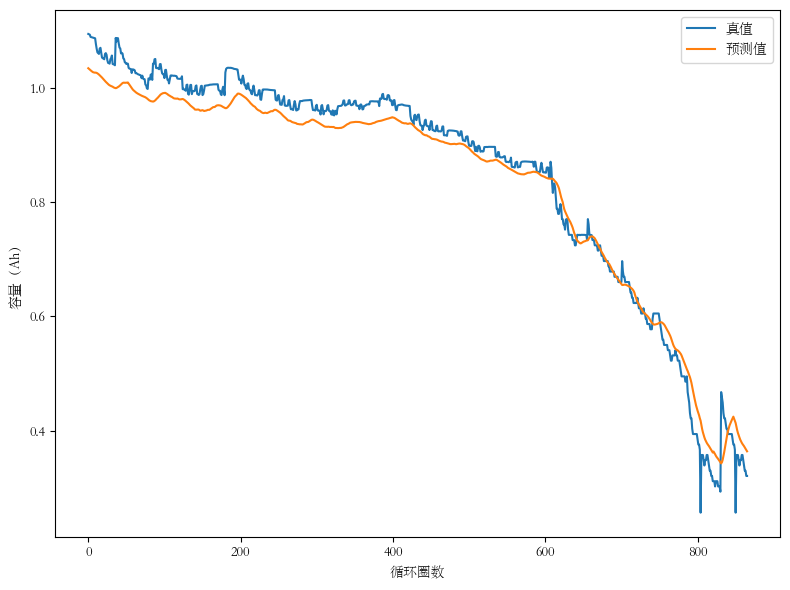

2023-05-15 10:45:25,522 - calce_lstm - INFO - test dataset: CS2_35, maxE: 0.160861, mae: 0.028106, rmse:0.033164
2023-05-15 10:45:25,522 - calce_lstm - INFO - test dataset: CS2_35, maxE: 0.160861, mae: 0.028106, rmse:0.033164


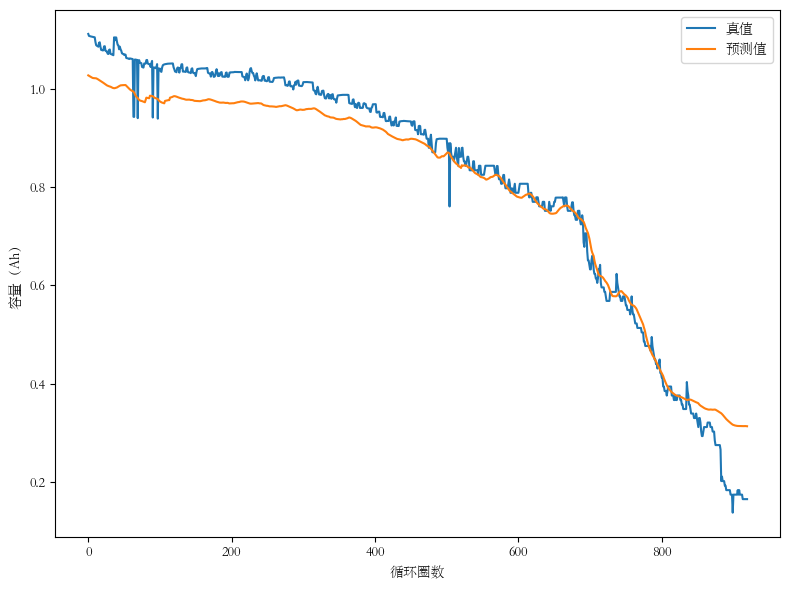

2023-05-15 10:46:50,337 - calce_lstm - INFO - test dataset: CS2_36, maxE: 0.179085, mae: 0.041033, rmse:0.051320
2023-05-15 10:46:50,337 - calce_lstm - INFO - test dataset: CS2_36, maxE: 0.179085, mae: 0.041033, rmse:0.051320


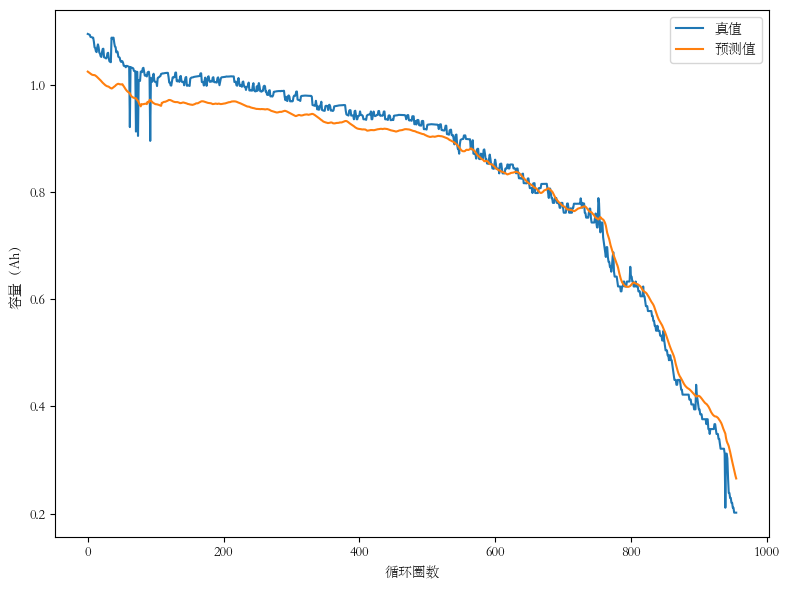

2023-05-15 10:48:12,516 - calce_lstm - INFO - test dataset: CS2_37, maxE: 0.138158, mae: 0.028373, rmse:0.033656
2023-05-15 10:48:12,516 - calce_lstm - INFO - test dataset: CS2_37, maxE: 0.138158, mae: 0.028373, rmse:0.033656


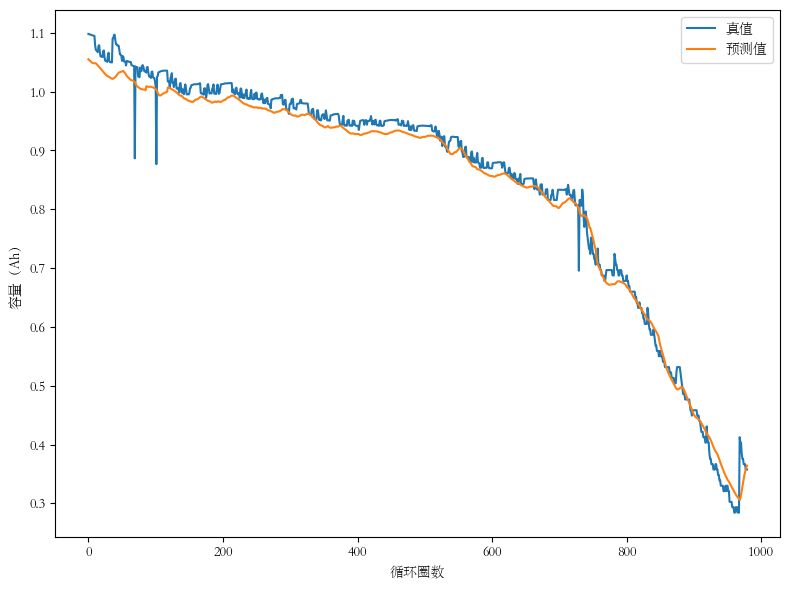

2023-05-15 10:49:34,940 - calce_lstm - INFO - test dataset: CS2_38, maxE: 0.130194, mae: 0.017837, rmse:0.022234
2023-05-15 10:49:34,940 - calce_lstm - INFO - test dataset: CS2_38, maxE: 0.130194, mae: 0.017837, rmse:0.022234


In [16]:
dataset = [bcs235, bcs236, bcs237, bcs238]
battery_names = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="calce_lstm"
    ).get_logger()

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)
    # print(train_dataset[0][0].shape, train_dataset[0][1].shape)

    model = LSTMNet(
        n_features=n_features,
        n_hidden=n_hidden,
        n_outputs=n_outputs,
        sequence_len=sequence_len,
        n_deep_layers=n_dnn_layers,
        use_cuda=USE_CUDA
    ).to(device)
    # model = LSTMNet(n_features, n_hidden, n_outputs, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
    # X, y = next(iter(train_dataloader))
    # print(X.shape, y.shape)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0.0, 0.0
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss = train_loss / len(train_dataloader)
        train_losses.append(epoch_loss)

        # 验证
        # model.eval()
        # for X, y in test_dataloader:
        #     with torch.no_grad():
        #         X, y = X.to(device), y.squeeze().to(device)
        #         preds = model(X).squeeze()
        #         error = criterion(preds, y)
        #     val_loss += error
        # val_loss = val_loss / len(test_dataloader)
        # val_losses.append(val_loss)

        # 打印训练和验证信息
        # print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    # 可视化验证集上结果hidden_sate
    y_pred, gt, y1, y2 = [], [], [], []
    cycle = [i + 1 for i in range(len(test_dataset))]
    for X, y in test_dataset:
        y = y.item()
        gt.append(y)
        y1.append(y * (1 + 0.05))
        y2.append(y * (1 - 0.05))
    model.eval()
    for cnt, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.squeeze().to(device)
        y_pred += model(X).cpu().squeeze().tolist()
        
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/calce_{battery_names[idx]}_lstm.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

    maxE, mae, rmse = metrics.evaluation(np.array(gt, dtype=object).flatten(), np.array(y_pred, dtype=object).flatten())
    logger.info(f"test dataset: {battery_names[idx]}, maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")

## NASA数据集

In [17]:
nasa_data_path = "../../data/processed_data/nasa/nasa_capacity.npy"
nasa_data = np.load(nasa_data_path, allow_pickle=True)
b05 = nasa_data[0].astype(np.float32)
b06 = nasa_data[1].astype(np.float32)
b07 = nasa_data[2].astype(np.float32)
b18 = nasa_data[3].astype(np.float32)

window_size = 16
b05 = sequence_target_generator(b05, window_size=window_size)
b06 = sequence_target_generator(b06, window_size=window_size)
b07 = sequence_target_generator(b07, window_size=window_size)
b18 = sequence_target_generator(b18, window_size=window_size)

Save log to: ../../logs/2023_05_15_10_49_nasa_lstm.log


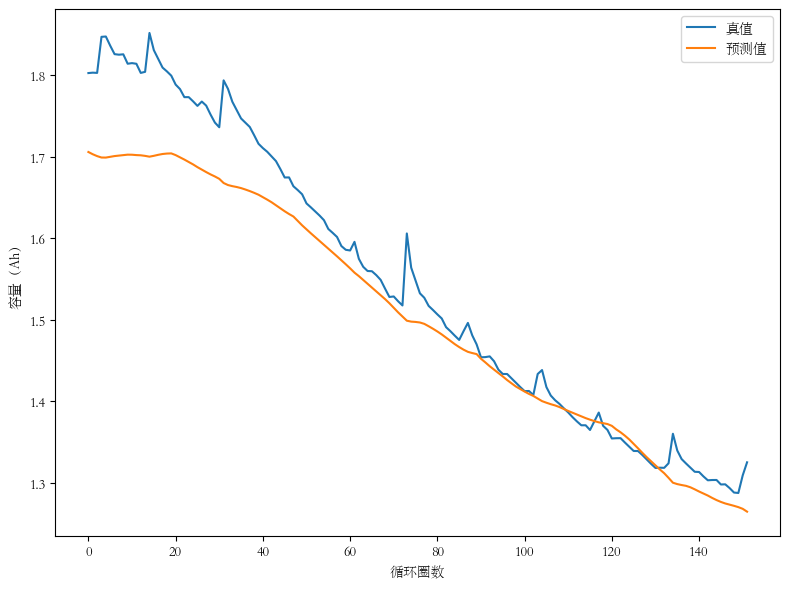

2023-05-15 10:50:30,375 - nasa_lstm - INFO - test dataset: B0005, maxE: 0.151790, mae: 0.041876, rmse:0.057897


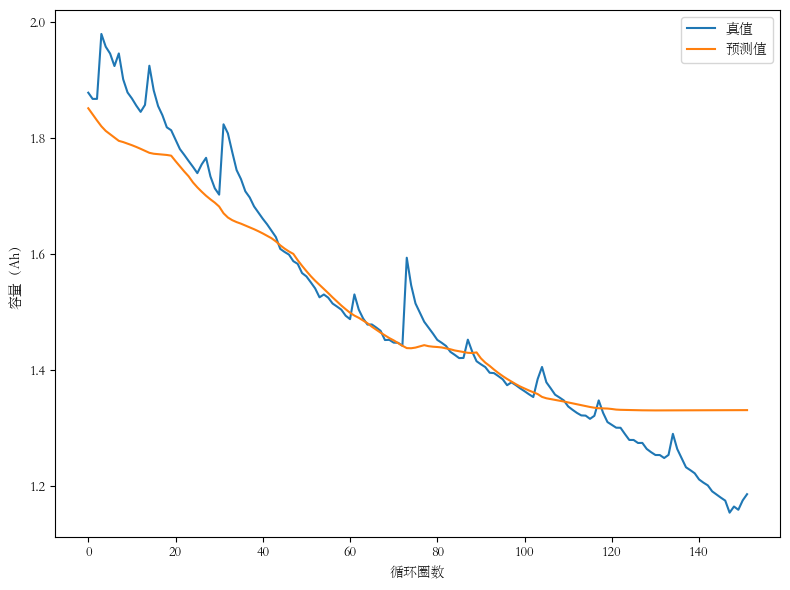

2023-05-15 10:51:24,155 - nasa_lstm - INFO - test dataset: B0006, maxE: 0.176740, mae: 0.047997, rmse:0.068772


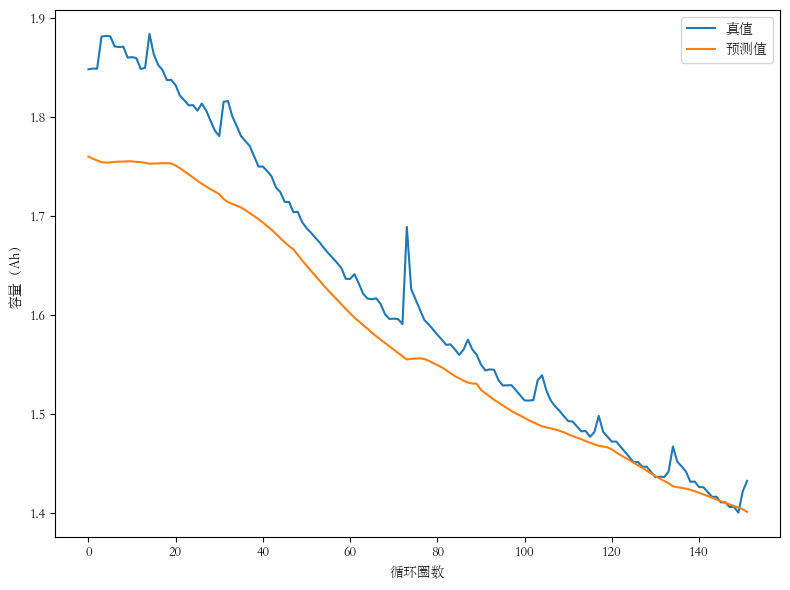

2023-05-15 10:52:19,167 - nasa_lstm - INFO - test dataset: B0007, maxE: 0.133804, mae: 0.042824, rmse:0.054669


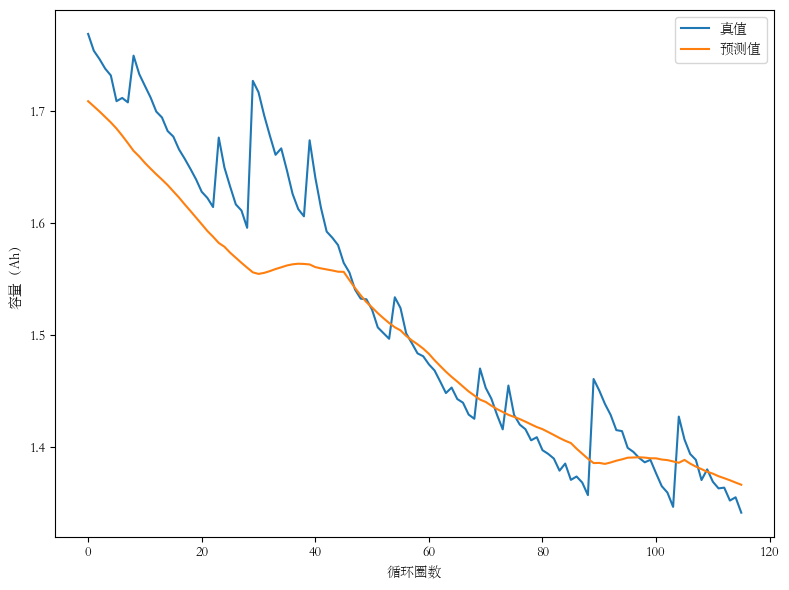

2023-05-15 10:53:17,915 - nasa_lstm - INFO - test dataset: B0018, maxE: 0.171014, mae: 0.034540, rmse:0.047809


In [18]:
dataset = [b05, b06, b07, b18]
battery_names = ['B0005', 'B0006', 'B0007', 'B0018']

logger = Logger(
        log_root_path="../../logs/",
        log_level=logging.DEBUG,
        logger_name="nasa_lstm"
    ).get_logger()

for idx in range(len(dataset)):
    train_dataset = dataset[: idx] + dataset[idx + 1: ]
    train_dataset = np.array([j for i in train_dataset for j in i], dtype=object)
    test_dataset = dataset[idx]

    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)

    model = LSTMNet(
        n_features=n_features,
        n_hidden=n_hidden,
        n_outputs=n_outputs,
        sequence_len=sequence_len,
        n_deep_layers=n_dnn_layers,
        use_cuda=USE_CUDA
    ).to(device)
    # model = LSTMNet(n_features, n_hidden, n_outputs, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

    train_losses, val_losses = [], []

    epochs = 950
    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = 0.0, 0.0
        
        # 训练
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        # epoch_loss = train_loss / len(train_dataloader)
        # train_losses.append(epoch_loss)

        # 验证
        # model.eval()
        # for X, y in test_dataloader:
        #     with torch.no_grad():
        #         X, y = X.to(device), y.squeeze().to(device)
        #         preds = model(X).squeeze()
        #         error = criterion(preds, y)
        #     val_loss += error
        # val_loss = val_loss / len(test_dataloader)
        # val_losses.append(val_loss)

        # 打印训练和验证信息
        # print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    # 可视化验证集上结果hidden_sate
    y_pred, gt, y1, y2 = [], [], [], []
    cycle = [i + 1 for i in range(len(test_dataset))]
    for X, y in test_dataset:
        y = y.item()
        gt.append(y)
        y1.append(y * (1 + 0.05))
        y2.append(y * (1 - 0.05))
    model.eval()
    for cnt, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y.squeeze().to(device)
        y_pred += model(X).cpu().squeeze().tolist()
        
    plt.figure(figsize=(8, 6))
    plt.plot(gt)
    plt.plot(y_pred)
    plt.legend(["真值", "预测值"])
    plt.xlabel("循环圈数")
    plt.ylabel("容量（Ah）")
    save_path = f"../../assets/thesis_figures/chapter_3/nasa_{battery_names[idx]}_lstm.jpg"
    plt.savefig(save_path, dpi=1000, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

    maxE, mae, rmse = metrics.evaluation(np.array(gt, dtype=object).flatten(), np.array(y_pred, dtype=object).flatten())
    logger.info(f"test dataset: {battery_names[idx]}, maxE: {maxE:7.6f}, mae: {mae:7.6f}, rmse:{rmse:7.6f}")